# Get Cocrystalized molecules from PDB

- Extract the cocrystalized molecules from the PDB structures.
- The active site is defined by a reference PDB structure and the name of the cocrystalized molecule (3-letter identifier code).

In [1]:
import itertools
import pandas as pd
import numpy as np
from pathlib import Path
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
# Read the metadata dataframe created in the previous notebook
prot_name = 'cdk2'
df_prot = pd.read_pickle(f'./df_metadata_{prot_name}_pdbids.pkl')

In [3]:
df_prot_ligs = df_prot[df_prot.NumLigs > 0]
print(F'{len(df_prot_ligs)} of {len(df_prot)} structures have at least one HETATM molecule.')

394 of 425 structures have at least one HETATM molecule.


In [4]:
# How many cocrystalized molecules are there?
# A set of all HETATM molecules
lig_full_list = list( itertools.chain.from_iterable( df_prot.NameLigs ) )
print(f'There are a total of {len(lig_full_list)}', 
       'HETATM molecules (duplicates included).')

lig_all_list = list(set(lig_full_list))
print(f'There are {len(lig_all_list)} unique', 
       'HETATM molecules (without duplicates).')

There are a total of 541 HETATM molecules (duplicates included).
There are 359 unique HETATM molecules (without duplicates).


## Visualize pocket residues

In [5]:
from helper_modules.get_cocristalized_ligands \
     import get_pocket_ligand, PocketResidues

In [6]:
# Use a reference structure to visualize the pocket residues
ref_struc_id    = '1fin'
ref_ligand_name = 'ATP'

In [7]:
pkt_info = PocketResidues(ref_struc_id, ref_ligand_name)
pocket_residues_str = pkt_info.get_pocket_residues_as_list(cutoff = 8)
print('Indices of pocket redsidues:', pocket_residues_str)

Indices of pocket redsidues: 9 10 11 12 13 14 15 16 17 18 19 20 30 31 32 33 47 51 64 65 79 80 81 82 83 84 85 86 87 88 89 127 129 130 131 132 133 134 135 142 143 144 145 146 147 148


In [8]:
view = pkt_info.visualize_pocket()
view

NGLWidget()

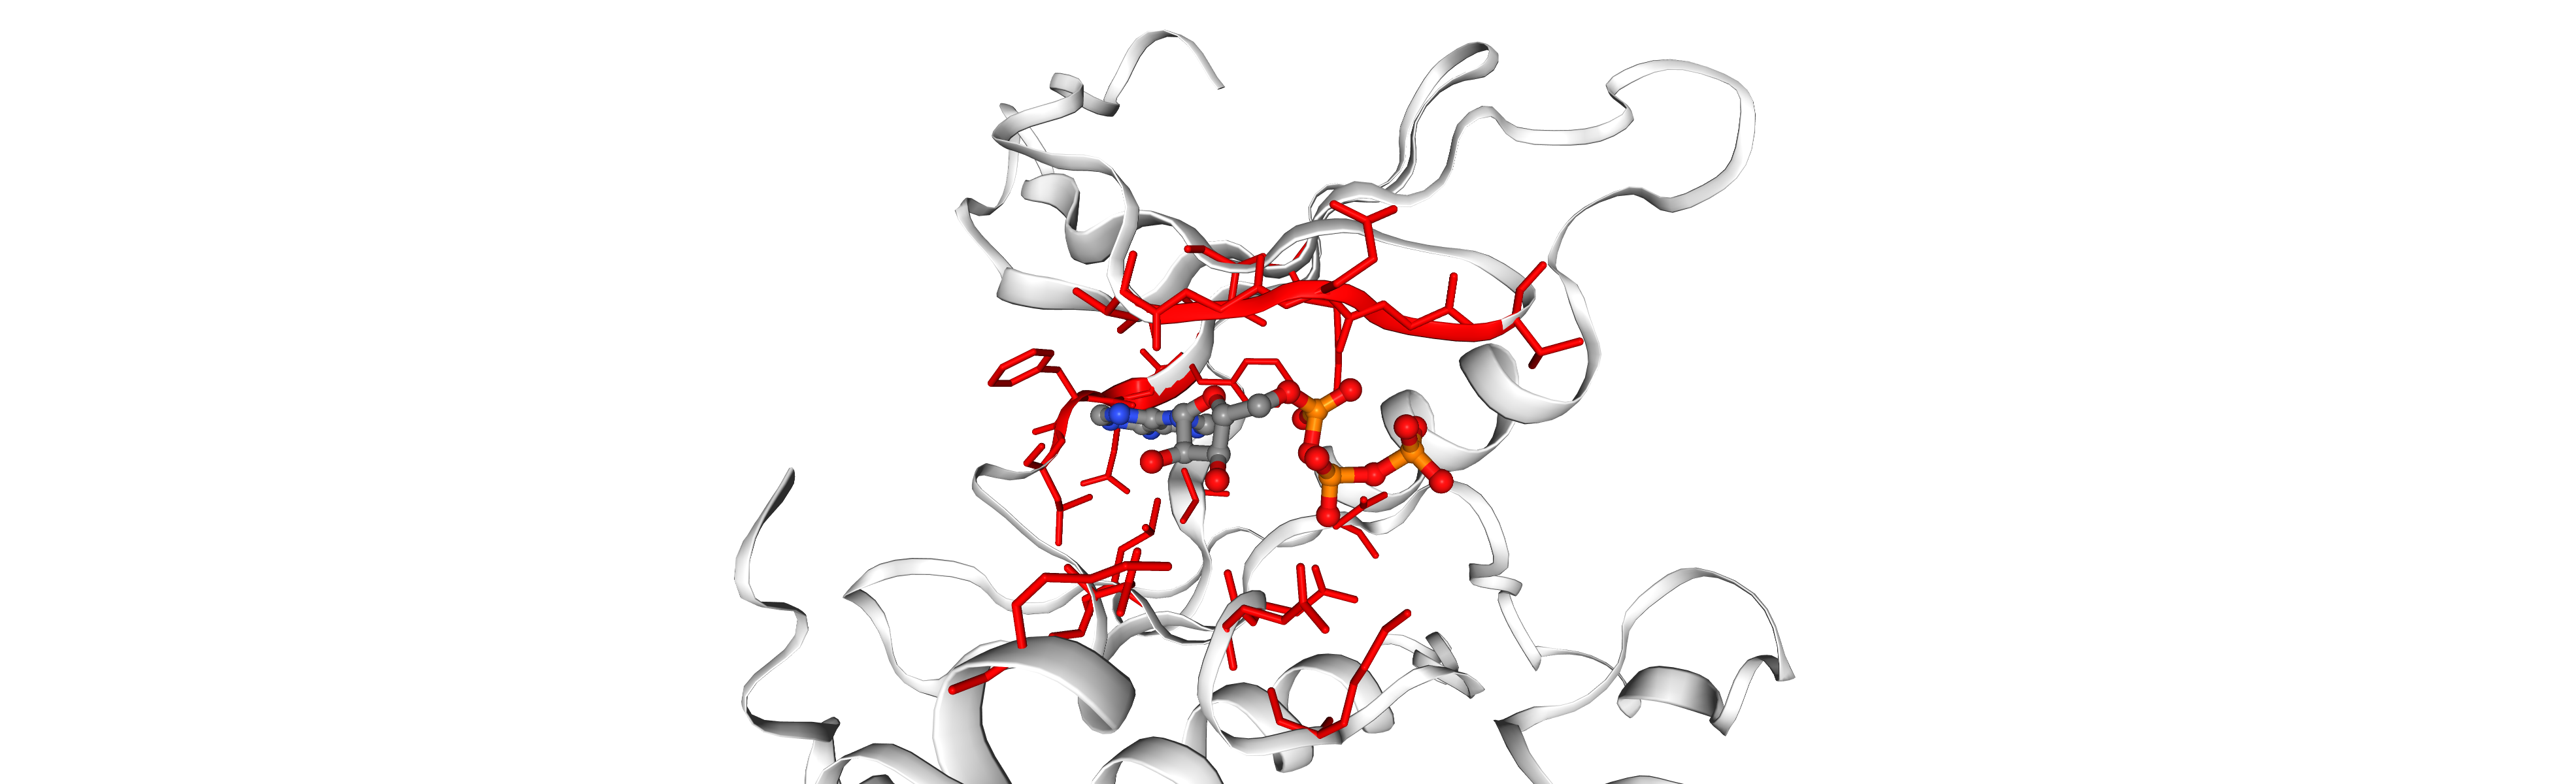

In [10]:
view.render_image()
view._display_image()

## Perform the analysis
### Identify and save the molecules bound to the active site

- Define the input files and the output directory.

In [12]:
# Define the output directories
OUT_MAIN           = '../../data/crystal_confs/'
IN_DIR_PROT_CHAINS = f'{OUT_MAIN}/pdb_modeled'
IN_DIR_RAW_LIGS    = f'{OUT_MAIN}/raw_ligands'
OUT_DIR_PREP_LIGS  = f'{OUT_MAIN}/pocket_ligands'

# Create the output directory if it doesnt exists
Path(OUT_DIR_PREP_LIGS).mkdir(parents = True, exist_ok = True)

Update the **metadata DataFrame** with the information of the ligands:
- `LigPktName`: Name of the molecule found inside the pocket.
- `LigMW`: Molecular weight of the molecule (no Hydrogens).
- `LigNHeavyAtoms`: Number of heavy atoms of the molecule.

**Criteria** to identify a molecule as a <mark>ligand bound to the protein pocket</mark> (active site):
- The molecule has a `HETATM` identifier.
- The geometric center of the molecule is at most 10 Angstroms from the geometric center of the pocket. 
    - As an example, for `3pxf` the ligand `2AN` is 9.05 Angstroms from the pocket.
- The molecule has at least 12 heavy atoms (`min_heavy_atoms`). 
    - The molecule is not a solvent molecule.
- If two or more molecules satisfy the above criteria:
    - Select the molecule closest to the protein's pocket geometric center.
    
Additionally, only the coordinates of the molecule identified as ligand will be saved in the `OUT_DIR_PREP_LIGS` directory.

In [13]:
# Get all pocket ligands
lig_names, lig_mws, lig_n_atoms, lig_distances = [], [], [], []

for pdb_id in df_prot['PDB_ID']:
    name, mw, num_heavy_atoms, dist = get_pocket_ligand(
                        pdb_id          = pdb_id, 
                        pocket_residues = pocket_residues_str,
                        raw_lig_dir     = IN_DIR_RAW_LIGS,
                        prot_chain_dir  = IN_DIR_PROT_CHAINS,
                        pk_ligs_dir     = OUT_DIR_PREP_LIGS,
                        write_files     = True, 
                        min_heavy_atoms = 12,
                        min_dist_from_pkt = 10
                 )
    lig_names.append(name) 
    lig_mws.append(mw)
    lig_n_atoms.append(num_heavy_atoms)
    lig_distances.append(dist)
    
df_prot_lig = df_prot.copy(deep = True)
df_prot_lig["LigPktName"]      = lig_names
df_prot_lig["LigMW"]           = lig_mws
df_prot_lig["LigNHeavyAtoms"]  = lig_n_atoms
df_prot_lig["LigDistToPocket"] = lig_distances

Protein 1aq1
	Molecules found: ['STU']
	-> ligand STU saved (2.55 A from pkt center, 35 atoms)
Protein 1b38
	Molecules found: ['ATP', 'MG']
	-> ligand ATP saved (3.00 A from pkt center, 31 atoms)
Protein 1b39
	Molecules found: ['ATP', 'MG']
	-> ligand ATP saved (3.01 A from pkt center, 31 atoms)
Protein 1buh
	The protein 1buh has no ligand inside the pocket.
Protein 1ckp
	Molecules found: ['EDO', 'PVB']
	-> ligand PVB saved (4.83 A from pkt center, 18 atoms)
Protein 1di8
	Molecules found: ['DTQ']
	-> ligand DTQ saved (2.75 A from pkt center, 22 atoms)
Protein 1dm2
	Molecules found: ['EDO', 'HMD']
	-> ligand HMD saved (1.75 A from pkt center, 19 atoms)
Protein 1e1v
	Molecules found: ['CMG']
	-> ligand CMG saved (3.01 A from pkt center, 18 atoms)
Protein 1e1x
	Molecules found: ['NW1']
	-> ligand NW1 saved (3.06 A from pkt center, 18 atoms)
Protein 1e9h
	Molecules found: ['INR', 'TPO']
	-> ligand INR saved (2.41 A from pkt center, 24 atoms)
Protein 1f5q
	The protein 1f5q has no ligand ins

	Molecules found: ['D23']
	-> ligand D23 saved (3.41 A from pkt center, 26 atoms)
Protein 2b54
	Molecules found: ['D05']
	-> ligand D05 saved (4.28 A from pkt center, 30 atoms)
Protein 2b55
	Molecules found: ['D31']
	-> ligand D31 saved (2.98 A from pkt center, 31 atoms)
Protein 2bhe
	Molecules found: ['BRY']
	-> ligand BRY saved (3.32 A from pkt center, 21 atoms)
Protein 2bhh
	Molecules found: ['RYU']
	-> ligand RYU saved (2.52 A from pkt center, 31 atoms)
Protein 2bkz
	Molecules found: ['SBC']
	-> ligand SBC saved (2.29 A from pkt center, 25 atoms)
Protein 2bpm
	Molecules found: ['529']
	-> ligand 529 saved (6.20 A from pkt center, 25 atoms)
Protein 2btr
	Molecules found: ['U73']
	-> ligand U73 saved (4.92 A from pkt center, 18 atoms)
Protein 2bts
	Molecules found: ['U32']
	-> ligand U32 saved (5.16 A from pkt center, 19 atoms)
Protein 2c4g
	Molecules found: ['514']
	-> ligand 514 saved (3.15 A from pkt center, 20 atoms)
Protein 2c5n
	Molecules found: ['CK8']
	-> ligand CK8 saved (2.

	Molecules found: ['MG', 'TPO']
	XXX The protein 2wmb has no ligand inside the pocket.
Protein 2wpa
	Molecules found: ['889']
	-> ligand 889 saved (1.36 A from pkt center, 26 atoms)
Protein 2wxv
	Molecules found: ['WXV']
	-> ligand WXV saved (2.73 A from pkt center, 29 atoms)
Protein 2x1n
	Molecules found: ['X1N']
	-> ligand X1N saved (2.99 A from pkt center, 24 atoms)
Protein 2xmy
	Molecules found: ['CDK']
	-> ligand CDK saved (4.74 A from pkt center, 29 atoms)
Protein 2xnb
	Molecules found: ['Y8L']
	-> ligand Y8L saved (4.08 A from pkt center, 27 atoms)
Protein 3bht
	Molecules found: ['MFR', 'TPO']
	-> ligand MFR saved (1.94 A from pkt center, 18 atoms)
Protein 3bhu
	Molecules found: ['MHR', 'TPO']
	-> ligand MHR saved (1.56 A from pkt center, 20 atoms)
Protein 3bhv
	Molecules found: ['TPO', 'VAR']
	-> ligand VAR saved (1.39 A from pkt center, 22 atoms)
Protein 3ddp
	Molecules found: ['RC8', 'TPO']
	-> ligand RC8 saved (4.96 A from pkt center, 32 atoms)
Protein 3ddq
	Molecules found:

	Molecules found: ['Z68']
	-> ligand Z68 saved (3.58 A from pkt center, 24 atoms)
Protein 3r9o
	Molecules found: ['Z71']
	-> ligand Z71 saved (2.94 A from pkt center, 28 atoms)
Protein 3rah
	Molecules found: ['O1Z']
	-> ligand O1Z saved (3.47 A from pkt center, 25 atoms)
Protein 3rai
	Molecules found: ['X85']
	-> ligand X85 saved (5.21 A from pkt center, 30 atoms)
Protein 3rak
	Molecules found: ['03Z']
	-> ligand 03Z saved (3.93 A from pkt center, 25 atoms)
Protein 3ral
	Molecules found: ['04Z']
	-> ligand 04Z saved (3.59 A from pkt center, 27 atoms)
Protein 3rjc
	Molecules found: ['06Z']
	-> ligand 06Z saved (3.54 A from pkt center, 22 atoms)
Protein 3rk5
	Molecules found: ['07Z']
	-> ligand 07Z saved (3.77 A from pkt center, 24 atoms)
Protein 3rk7
	Molecules found: ['08Z']
	-> ligand 08Z saved (3.60 A from pkt center, 24 atoms)
Protein 3rk9
	Molecules found: ['09Z']
	-> ligand 09Z saved (2.30 A from pkt center, 18 atoms)
Protein 3rkb
	Molecules found: ['12Z']
	-> ligand 12Z saved (3.

	Molecules found: ['60K', 'DTT']
	-> ligand 60K saved (3.37 A from pkt center, 25 atoms)
Protein 4gcj
	Molecules found: ['EDO', 'X64']
	-> ligand X64 saved (3.28 A from pkt center, 28 atoms)
Protein 4i3z
	Molecules found: ['ADP', 'CL', 'GOL', 'MG', 'TPO']
	-> ligand ADP saved (1.43 A from pkt center, 27 atoms)
Protein 4ii5
	Molecules found: ['ADP', 'GOL', 'MG', 'TPO']
	-> ligand ADP saved (1.56 A from pkt center, 27 atoms)
Protein 4kd1
	Molecules found: ['1QK', 'EDO']
	-> ligand 1QK saved (4.28 A from pkt center, 29 atoms)
Protein 4lyn
	Molecules found: ['1YG']
	-> ligand 1YG saved (3.49 A from pkt center, 27 atoms)
Protein 4nj3
	Molecules found: ['2KD']
	-> ligand 2KD saved (3.96 A from pkt center, 36 atoms)
Protein 4rj3
	Molecules found: ['3QS', 'ACT', 'ALY']
	-> ligand 3QS saved (3.20 A from pkt center, 29 atoms)
Protein 5a14
	Molecules found: ['LQ5']
	-> ligand LQ5 saved (6.44 A from pkt center, 36 atoms)
Protein 5and
	Molecules found: ['5JE']
	-> ligand 5JE saved (4.85 A from pkt 

## Save the updated DataFrame

In [14]:
file = f'./df_metadata_{prot_name}_pdbids_LIGS.pkl'
df_prot_lig = pd.read_pickle(file)
df_prot_lig.sample(10)

,PDB_ID,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,NonStndResnames,NonStndResnums,LigPktName,LigMW,LigNHeavyAtoms,LigDistToPocket
37,1hcl,high-resolution crystal structures of human cy...,1996-12-07,1,A,1.8,0.993,98.658,1,[4],"[[37, 40]]",0,[],None,None,None,NaN,NaN,NaN
70,1pxp,2-anilino-4-(thiazol-5-yl)pyrimidine cdk inhib...,2004-04-13,1,A,2.3,0.993,98.658,1,[4],"[[37, 40]]",1,[CK8],None,None,CK8,306.280400,23.0,3.992356
304,4bzd,structure of cdk2 in complex with a benzimidaz...,2014-08-13,1,A,1.83,0.993,92.953,3,"[1, 6, 14]","[[14, 14], [38, 43], [149, 162]]",2,"[D6I, ACT]",None,None,D6I,366.271000,29.0,3.974321
131,2r3j,structure-guided discovery of cyclin-dependent...,2008-01-22,1,A,1.65,0.993,93.289,3,"[8, 11, 1]","[[36, 43], [151, 161], [177, 177]]",1,[SCJ],None,None,SCJ,366.130100,24.0,3.773699
248,3r7u,structure-guided optimization of novel cdk2 in...,2012-08-08,1,A,1.75,0.993,94.631,2,"[8, 8]","[[37, 44], [155, 162]]",2,"[X96, EDO]",None,None,X96,284.185500,22.0,5.089352
134,2r3m,structure-guided discovery of cyclin-dependent...,2008-01-22,1,A,1.7,0.993,93.289,3,"[8, 11, 1]","[[36, 43], [151, 161], [177, 177]]",1,[SCX],None,None,SCX,364.247006,28.0,3.414591
282,3s0o,development of highly potent and selective dia...,2012-10-31,1,A,2.0,0.993,98.322,2,"[3, 2]","[[38, 40], [147, 148]]",1,[50Z],None,None,50Z,248.219600,18.0,2.395644
97,2bts,structure-based drug design to the discovery o...,2005-11-09,1,A,1.99,0.993,91.946,2,"[9, 15]","[[37, 45], [149, 163]]",1,[U32],None,None,U32,282.277300,19.0,5.175933
334,4fkj,crystal structure of the cdk2 in complex with ...,2013-05-08,1,A,1.63,0.993,93.289,2,"[9, 11]","[[36, 44], [152, 162]]",2,"[11K, ACT]",None,None,11K,328.239600,26.0,7.252772
340,4fks,crystal structure of the cdk2 in complex with ...,2013-05-08,1,A,1.55,0.993,92.282,3,"[9, 12, 2]","[[36, 44], [151, 162], [296, 297]]",1,[46K],None,None,46K,414.458160,28.0,4.572343
